## Unsupervised Learning Capstone:

For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import spacy
import re
import gensim

import time
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
from nltk.corpus import reuters, stopwords

#each file is pre-labeled for train (~73%) and test (remaining 27%)
train_files = list(filter(lambda x: x.startswith('training'), reuters.fileids()))
test_files = list(filter(lambda x: x.startswith('test'), reuters.fileids()))

print(train_files[:3])
print(test_files[:3])
print(len(train_files))
print(len(test_files))

['training/1', 'training/10', 'training/100']
['test/14826', 'test/14828', 'test/14829']
7769
3019


In [3]:
#see what this data looks like
train_raw = reuters.raw(train_files)
test_raw = reuters.raw(test_files)

print(train_raw[:500])

BAHIA COCOA REVIEW
  Showers continued throughout the week in
  the Bahia cocoa zone, alleviating the drought since early
  January and improving prospects for the coming temporao,
  although normal humidity levels have not been restored,
  Comissaria Smith said in its weekly review.
      The dry period means the temporao will be late this year.
      Arrivals for the week ended February 22 were 155,221 bags
  of 60 kilos making a cumulative total for the season of 5.93
  mln against 5.81 at th


In [4]:
#text cleaning function
def text_cleaner(text):
    text = re.sub(r'--',' ', text) #double hyphens cause problems
    text = re.sub('[^A-Za-z0-9]+', ' ', text) #matches characters that are not letters or numbers
    text = re.sub(r'\d+','', text) #this handles digits
    
    #comparison operators format weird
    text = re.sub(r'&lt;', ' ', text)
    text = re.sub(r'&gt;', ' ', text)
    text = re.sub(r'&le;', ' ', text)
    text = re.sub(r'&ge;', ' ', text)
    
    #lowercase and join
    text = text.lower()
    text = ' '.join(text.split())
    return text

In [5]:
#populate train df
train_df = pd.DataFrame()
for file in train_files:
    if len(reuters.categories(file)) == 1:
        train_df = train_df.append({
            'category':''.join(reuters.categories(file)),
            'fileid':file,
            'text':text_cleaner(reuters.raw([file]))}, ignore_index=True)

#inspect results        
print('\n{} train files; data shape is {}'.format(
    len(train_files), train_df.shape))
print('articles eliminated: {}\n'.format(len(train_files) - len(train_df)))
print('dataframe head: \n{}'.format(train_df.head()))

#populate test df
test_df = pd.DataFrame()
for file in test_files:
    if len(reuters.categories(file)) == 1:
        test_df = test_df.append({
            'category':''.join(reuters.categories(file)),
            'fileid':file,
            'text':text_cleaner(reuters.raw(file))}, ignore_index=True)

#inspect results
print('\n{} test files; data shape is {}'.format(len(
    test_files), test_df.shape))
print('articles eliminated: {}\n'.format(len(test_files) - len(test_df)))
print('dataframe head: \n{}'.format(test_df.head()))


7769 train files; data shape is (6577, 3)
articles eliminated: 1192

dataframe head: 
       category          fileid  \
0         cocoa      training/1   
1           acq     training/10   
2  money-supply    training/100   
3           acq   training/1000   
4          earn  training/10000   

                                                text  
0  bahia cocoa review showers continued throughou...  
1  computer terminal systems lt cpml completes sa...  
2  n z trading bank deposit growth rises slightly...  
3  national amusements again ups viacom lt via bi...  
4  rogers lt rog sees st qtr net up significantly...  

3019 test files; data shape is (2583, 3)
articles eliminated: 436

dataframe head: 
  category      fileid                                               text
0    trade  test/14826  asian exporters fear damage from u s japan rif...
1    grain  test/14828  china daily says vermin eat pct grain stocks a...
2     ship  test/14839  australian foreign ship ban ends but nsw 

In [6]:
#does the test set contain any categories that the train set doesn't?
print(train_df['category'].nunique())
print(test_df['category'].nunique())
print(len(reuters.categories()))

train_cats = train_df['category'].unique()
test_cats = test_df['category'].unique()

print('\n{} cats in test not in train:\n{}'.format(
    len([x for x in test_cats if x not in train_cats]),
    [x for x in test_cats if x not in train_cats]))
print('\n{} cats in train not in test:\n{}'.format(
    len([x for x in train_cats if x not in test_cats]),
    [x for x in train_cats if x not in test_cats]))

#guessing rape-oil and rapeseed are typos?
print('\n{} cats not in train or test:\n{}'.format(
    len(list(set(reuters.categories()) - set(train_cats) - set(test_cats))),
    list(set(reuters.categories()) - set(train_cats) - set(test_cats))))

58
59
90

7 cats in test not in train:
['groundnut', 'rice', 'yen', 'hog', 'naphtha', 'propane', 'coconut']

6 cats in train not in test:
['oilseed', 'nzdlr', 'silver', 'dmk', 'l-cattle', 'rand']

25 cats not in train or test:
['lin-oil', 'coconut-oil', 'soybean', 'sun-meal', 'sun-oil', 'sorghum', 'soy-oil', 'rape-oil', 'copra-cake', 'corn', 'rye', 'nkr', 'castor-oil', 'dfl', 'palladium', 'sunseed', 'barley', 'palmkernel', 'oat', 'wheat', 'cotton-oil', 'soy-meal', 'groundnut-oil', 'palm-oil', 'rapeseed']


In [7]:
#drop cats that are exclusive to train/test
train_df = train_df[~train_df['category'].isin(
    [x for x in train_cats if x not in test_cats])]
test_df = test_df[~test_df['category'].isin(
    [x for x in test_cats if x not in train_cats])]

#should print true if above worked
print(train_df['category'].nunique() == test_df['category'].nunique())

True


In [8]:
#top categories to focus on
print('train:\n{}'.format(train_df['category'].value_counts()[:7]))
print('test:\n{}'.format(test_df['category'].value_counts()[:7]))

train:
earn            2840
acq             1596
crude            253
trade            250
money-fx         222
interest         191
money-supply     123
Name: category, dtype: int64
test:
earn        1083
acq          696
crude        121
money-fx      87
interest      81
trade         76
ship          36
Name: category, dtype: int64


In [9]:
#train: separate classes to focus on
train_earn = train_df.loc[train_df['category'] == 'earn']
train_acq = train_df.loc[train_df['category'] == 'acq']
train_crude = train_df.loc[train_df['category'] == 'crude']
train_trade = train_df.loc[train_df['category'] == 'trade']
train_money = train_df.loc[train_df['category'] == 'money-fx']

from sklearn.model_selection import train_test_split

#set data/target for classes
X_train_earn, X_val_earn, y_train_earn, y_val_earn = train_test_split(
    train_earn['text'], train_earn['category'], test_size=0.25)

X_train_acq, X_val_acq, y_train_acq, y_val_acq = train_test_split(
    train_acq['text'], train_acq['category'], test_size=0.25)

X_train_crude, X_val_crude, y_train_crude, y_val_crude = train_test_split(
    train_crude['text'], train_crude['category'], test_size=0.25)

X_train_trade, X_val_trade, y_train_trade, y_val_trade = train_test_split(
    train_trade['text'], train_trade['category'], test_size=0.25)

X_train_money, X_val_money, y_train_money, y_val_money = train_test_split(
    train_money['text'], train_money['category'], test_size=0.25)

#earn vs acq
X_train = pd.concat([X_train_earn, X_train_acq])
X_val = pd.concat([X_val_earn, X_val_acq])
y_train = pd.concat([y_train_earn, y_train_acq])
y_val = pd.concat([y_val_earn, y_val_acq])

#crude vs trade vs money
X_train_ = pd.concat([X_train_crude, X_train_trade, X_train_money])
X_val_ = pd.concat([X_val_crude, X_val_trade, X_val_money])
y_train_ = pd.concat([y_train_crude, y_train_trade, y_train_money])
y_val_ = pd.concat([y_val_crude, y_val_trade, y_val_money])

In [10]:
#test: separate classes
test_earn = test_df.loc[test_df['category'] == 'earn']
test_acq = test_df.loc[test_df['category'] == 'acq']
test_crude = test_df.loc[test_df['category'] == 'crude']
test_trade = test_df.loc[test_df['category'] == 'trade']
test_money = test_df.loc[test_df['category'] == 'money-fx']

#earn vs acq
X_test = pd.concat([test_earn['text'], test_acq['text']])
y_test = pd.concat([test_earn['category'], test_acq['category']])

#crude vs trade vs money
X_test_ = pd.concat(
    [test_crude['text'], test_trade['text'], test_money['text']])
y_test_ = pd.concat(
    [test_crude['category'], test_trade['category'], test_money['category']])

## tf-idf feature generation

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=2,
                             stop_words='english',
                             lowercase=False,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True)

In [12]:
#earn vs acq: train vectors
X_train_tfidf = vectorizer.fit_transform(X_train)
print('train features: {}'.format(X_train_tfidf.get_shape()[1]))

X_train_tfidf_csr = X_train_tfidf.tocsr()
n = X_train_tfidf_csr.shape[0]
tfidf_dicts = [{} for _ in range(0,n)]
terms = vectorizer.get_feature_names()

for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_dicts[i][terms[j]] = X_train_tfidf_csr[i,j]

#validate vectors
X_val_tfidf = vectorizer.fit_transform(X_val)
print('validate features: {}'.format(X_val_tfidf.get_shape()[1]))

X_val_tfidf_csr = X_val_tfidf.tocsr()
n = X_val_tfidf_csr.shape[0]
tfidf_dicts = [{} for _ in range(0,n)]
terms = vectorizer.get_feature_names()

for i, j in zip(*X_val_tfidf_csr.nonzero()):
    tfidf_dicts[i][terms[j]] = X_val_tfidf_csr[i,j]
    
#test vectors
X_test_tfidf = vectorizer.fit_transform(X_test)
print('test features: {}'.format(X_test_tfidf.get_shape()[1]))

X_test_tfidf_csr = X_test_tfidf.tocsr()
n = X_test_tfidf_csr.shape[0]
tfidf_dicts = [{} for _ in range(0,n)]
terms = vectorizer.get_feature_names()

for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_dicts[i][terms[j]] = X_test_tfidf_csr[i,j]

train features: 6507
validate features: 3029
test features: 3995


In [13]:
#crude vs trade vs money: train vectors
X_train_tfidf_ = vectorizer.fit_transform(X_train_)
print('train features: {}'.format(X_train_tfidf_.get_shape()[1]))

X_train_tfidf_csr_ = X_train_tfidf_.tocsr()
n_ = X_train_tfidf_csr_.shape[0]
tfidf_dicts_ = [{} for _ in range(0,n)]
terms_ = vectorizer.get_feature_names()

for i, j in zip(*X_train_tfidf_csr_.nonzero()):
    tfidf_dicts_[i][terms_[j]] = X_train_tfidf_csr_[i,j]

#validate vectors
X_val_tfidf_ = vectorizer.fit_transform(X_val_)
print('validate features: {}'.format(X_val_tfidf_.get_shape()[1]))

X_val_tfidf_csr_ = X_val_tfidf_.tocsr()
n_ = X_val_tfidf_csr_.shape[0]
tfidf_dicts_ = [{} for _ in range(0,n)]
terms_ = vectorizer.get_feature_names()

for i, j in zip(*X_val_tfidf_csr_.nonzero()):
    tfidf_dicts_[i][terms_[j]] = X_val_tfidf_csr_[i,j]
    
#test vectors
X_test_tfidf_ = vectorizer.fit_transform(X_test_)
print('test features: {}'.format(X_test_tfidf_.get_shape()[1]))

X_test_tfidf_csr_ = X_test_tfidf_.tocsr()
n_ = X_test_tfidf_csr_.shape[0]
tfidf_dicts_ = [{} for _ in range(0,n)]
terms_ = vectorizer.get_feature_names()

for i, j in zip(*X_test_tfidf_csr_.nonzero()):
    tfidf_dicts_[i][terms_[j]] = X_test_tfidf_csr_[i,j]

train features: 3866
validate features: 2064
test features: 2430


## Clustering: earn vs acq

In [14]:
from sklearn.preprocessing import normalize, Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

X_train_norm = normalize(X_train_tfidf)
X_val_norm = normalize(X_val_tfidf)

X_train_svd = TruncatedSVD(2).fit_transform(X_train_norm)
X_val_svd = TruncatedSVD(2).fit_transform(X_val_norm)

n_clust = 2

### Ground Truth

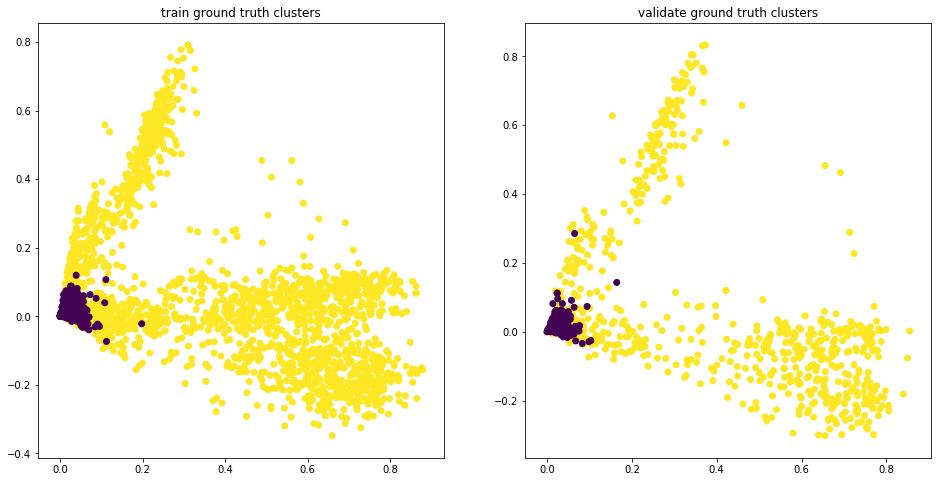

In [15]:
y_train_gt = pd.Categorical(y_train).codes
y_val_gt = pd.Categorical(y_val).codes

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_gt)
plt.title('train ground truth clusters')

plt.subplot(122)
plt.scatter(X_val_svd[:, 0], X_val_svd[:, 1], c=y_val_gt)
plt.title('validate ground truth clusters')
plt.show()

### k-means

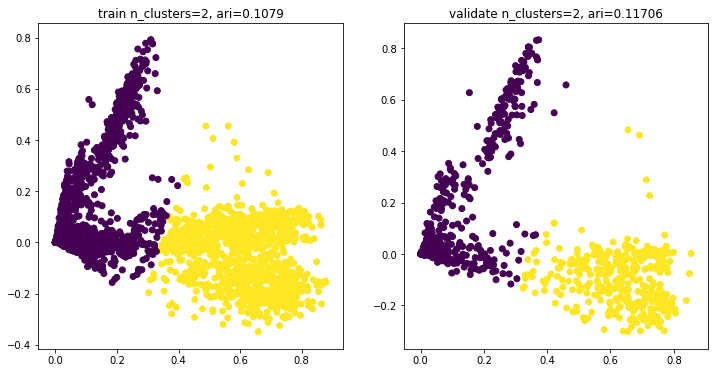

In [16]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

kmeans = KMeans(n_clusters=n_clust,
                init='k-means++',
                n_init=10).fit(X_train_svd)

y_pred_train = kmeans.predict(X_train_svd)
y_pred_val = kmeans.predict(X_val_svd)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_pred_train)
plt.title('train n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_train, y_pred_train)))

plt.subplot(122)
plt.scatter(X_val_svd[:,0], X_val_svd[:,1], c=y_pred_val)
plt.title('validate n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_val, y_pred_val)))
plt.show()

### MiniBatchKMeans

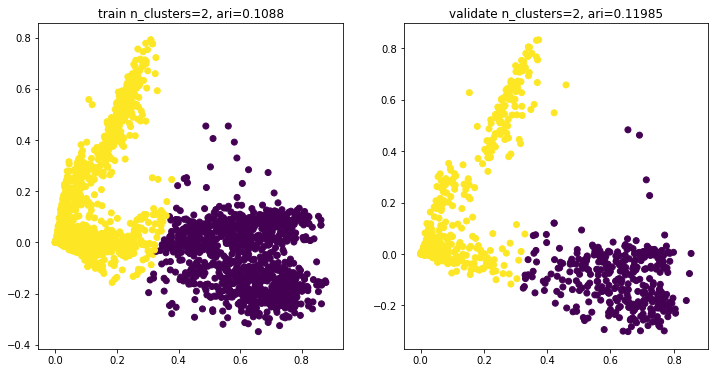

In [17]:
mbkmeans = MiniBatchKMeans(init='random',
                           n_clusters=n_clust,
                           batch_size=100).fit(X_train_svd)

predict_mini_train = mbkmeans.predict(X_train_svd)
predict_mini_val = mbkmeans.predict(X_val_svd)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=predict_mini_train)
plt.title('train n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_train, predict_mini_train)))

plt.subplot(122)
plt.scatter(X_val_svd[:,0], X_val_svd[:,1], c=predict_mini_val)
plt.title('validate n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_val, predict_mini_val)))
plt.show()

### Spectral Clustering

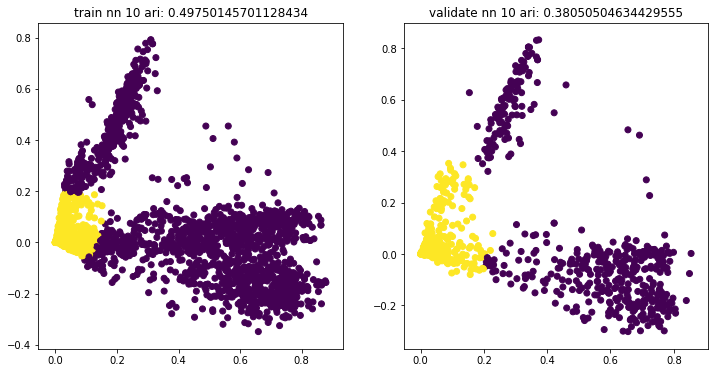

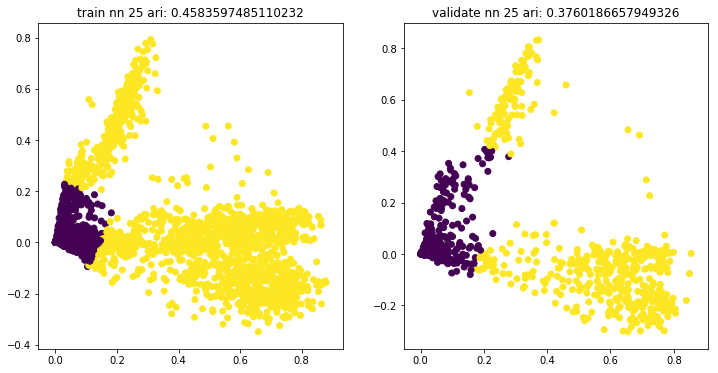

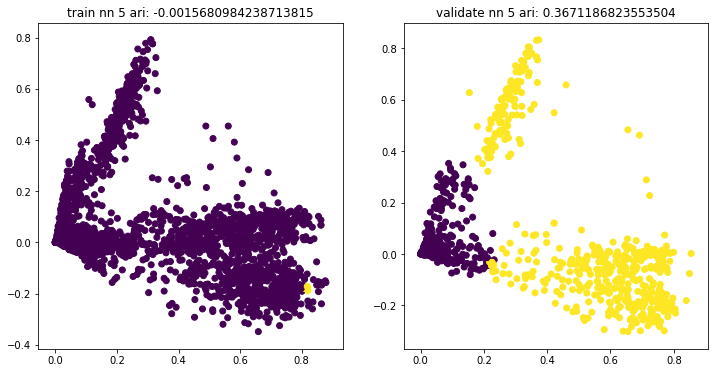

In [18]:
from sklearn.cluster import SpectralClustering

#nearest neighbors = 10
sc_nn10 = SpectralClustering(n_clusters=n_clust,
                             affinity='nearest_neighbors',
                             n_neighbors=10).fit(X_train_svd)

predict_nn10_train = sc_nn10.fit_predict(X_train_svd)
predict_nn10_val = sc_nn10.fit_predict(X_val_svd)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_nn10_train)
plt.title('train nn 10 ari: {}'.format(adjusted_rand_score(
    y_train, predict_nn10_train)))

plt.subplot(122)
plt.scatter(X_val_svd[:,0], X_val_svd[:,1], c=predict_nn10_val)
plt.title('validate nn 10 ari: {}'.format(
    adjusted_rand_score(y_val, predict_nn10_val)))
plt.show()

#nearest neighbors = 25
sc_nn25 = SpectralClustering(n_clusters=n_clust,
                             affinity='nearest_neighbors',
                             n_neighbors=25).fit(X_train_svd)

predict_nn25_train = sc_nn25.fit_predict(X_train_svd)
predict_nn25_val = sc_nn25.fit_predict(X_val_svd)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_nn25_train)
plt.title('train nn 25 ari: {}'.format(adjusted_rand_score(
    y_train, predict_nn25_train)))

plt.subplot(122)
plt.scatter(X_val_svd[:,0], X_val_svd[:,1], c=predict_nn25_val)
plt.title('validate nn 25 ari: {}'.format(
    adjusted_rand_score(y_val, predict_nn25_val)))
plt.show()

#nearest neighbors = 5
sc_nn5 = SpectralClustering(n_clusters=n_clust,
                            affinity='nearest_neighbors',
                            n_neighbors=5).fit(X_train_svd)

predict_nn5_train = sc_nn5.fit_predict(X_train_svd)
predict_nn5_val = sc_nn5.fit_predict(X_val_svd)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_nn5_train)
plt.title('train nn 5 ari: {}'.format(adjusted_rand_score(
    y_train, predict_nn5_train)))

plt.subplot(122)
plt.scatter(X_val_svd[:,0], X_val_svd[:,1], c=predict_nn5_val)
plt.title('validate nn 5 ari: {}'.format(
    adjusted_rand_score(y_val, predict_nn5_val)))
plt.show()

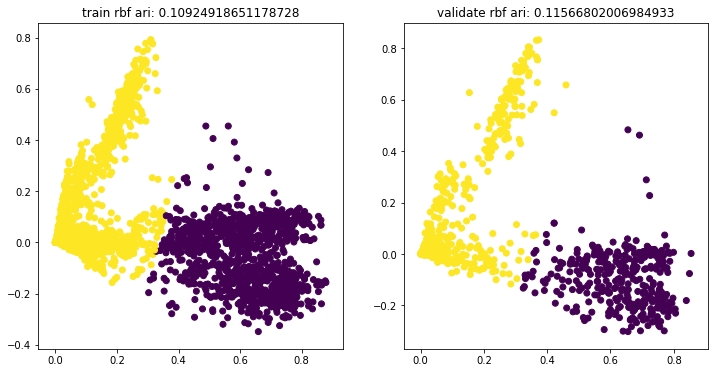

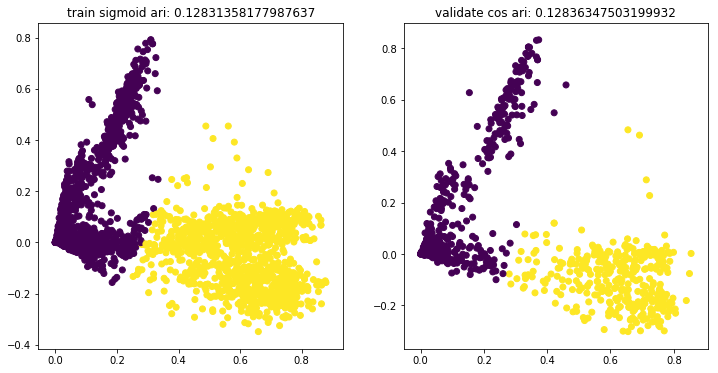

In [19]:
#rbf
sc_rbf = SpectralClustering(n_clusters=n_clust,
                            affinity='rbf').fit(X_train_svd)

predict_rbf_train = sc_rbf.fit_predict(X_train_svd)
predict_rbf_val = sc_rbf.fit_predict(X_val_svd)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_rbf_train)
plt.title('train rbf ari: {}'.format(adjusted_rand_score(
    y_train, predict_rbf_train)))

plt.subplot(122)
plt.scatter(X_val_svd[:,0], X_val_svd[:,1], c=predict_rbf_val)
plt.title('validate rbf ari: {}'.format(
    adjusted_rand_score(y_val, predict_rbf_val)))
plt.show()

#sigmoid
sc_sig = SpectralClustering(n_clusters=n_clust,
                            affinity='sigmoid').fit(X_train_svd)

predict_sig_train = sc_sig.fit_predict(X_train_svd)
predict_sig_val = sc_sig.fit_predict(X_val_svd)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_sig_train)
plt.title('train sigmoid ari: {}'.format(adjusted_rand_score(
    y_train, predict_sig_train)))

plt.subplot(122)
plt.scatter(X_val_svd[:,0], X_val_svd[:,1], c=predict_sig_val)
plt.title('validate sigmoid ari: {}'.format(
    adjusted_rand_score(y_val, predict_sig_val)))
plt.show()

## Clustering: crude vs trade vs money

In [20]:
X_train_norm_ = normalize(X_train_tfidf_)
X_val_norm_ = normalize(X_val_tfidf_)

X_train_svd_ = TruncatedSVD(2).fit_transform(X_train_norm_)
X_val_svd_ = TruncatedSVD(2).fit_transform(X_val_norm_)

n_clust_ = 3

### Ground Truth

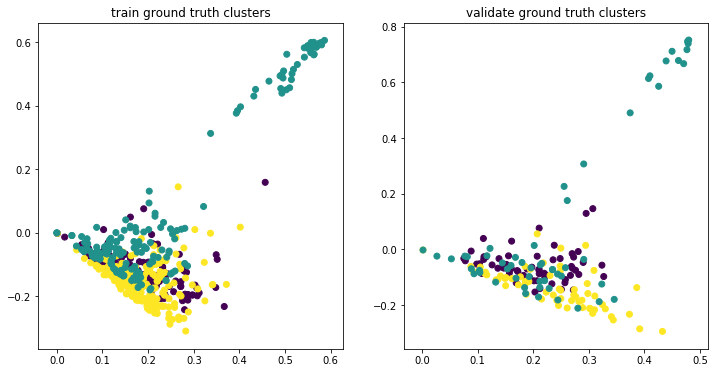

In [21]:
y_train_gt_ = pd.Categorical(y_train_).codes
y_val_gt_ = pd.Categorical(y_val_).codes

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:, 0], X_train_svd_[:, 1], c=y_train_gt_)
plt.title('train ground truth clusters')

plt.subplot(122)
plt.scatter(X_val_svd_[:, 0], X_val_svd_[:, 1], c=y_val_gt_)
plt.title('validate ground truth clusters')
plt.show()

### k-means

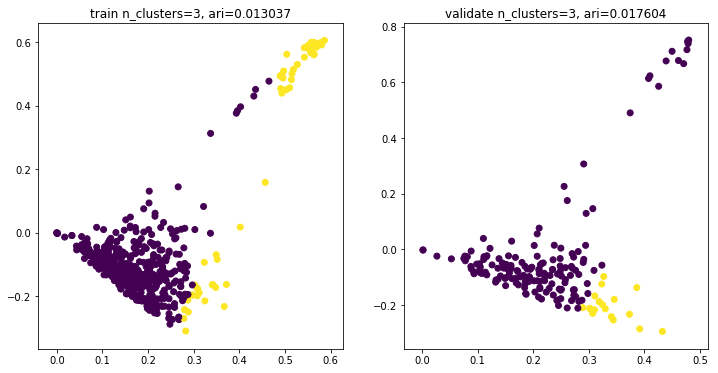

In [22]:
kmeans_ = KMeans(n_clusters=n_clust_,
                 init='k-means++',
                 n_init=10).fit(X_train_svd_)

y_pred_train_ = kmeans.predict(X_train_svd_)
y_pred_val_ = kmeans.predict(X_val_svd_)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:, 0], X_train_svd_[:, 1], c=y_pred_train_)
plt.title('train n_clusters=3, ari={:0.5}'.format(
    adjusted_rand_score(y_train_, y_pred_train_)))

plt.subplot(122)
plt.scatter(X_val_svd_[:,0], X_val_svd_[:,1], c=y_pred_val_)
plt.title('validate n_clusters=3, ari={:0.5}'.format(
    adjusted_rand_score(y_val_, y_pred_val_)))
plt.show()

### Spectral Clustering

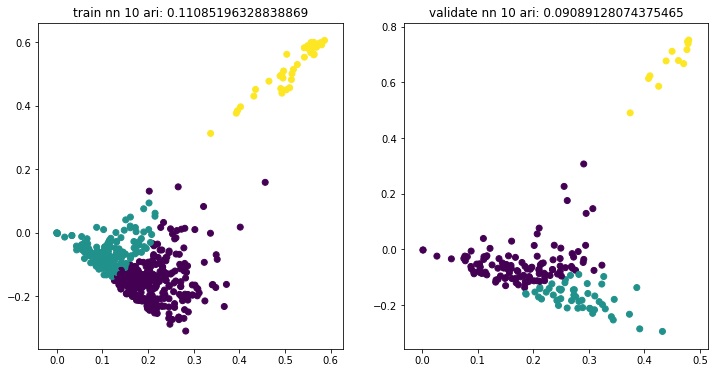

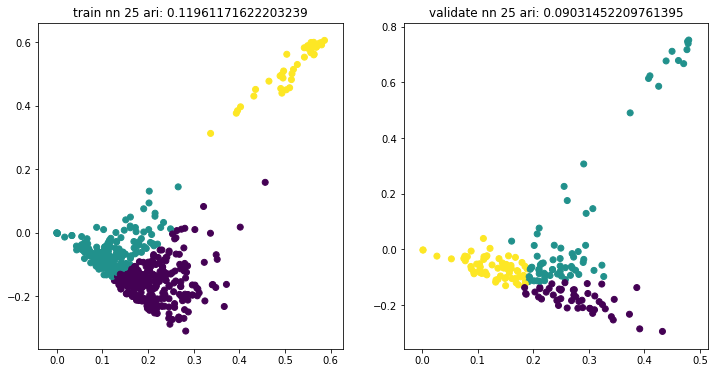

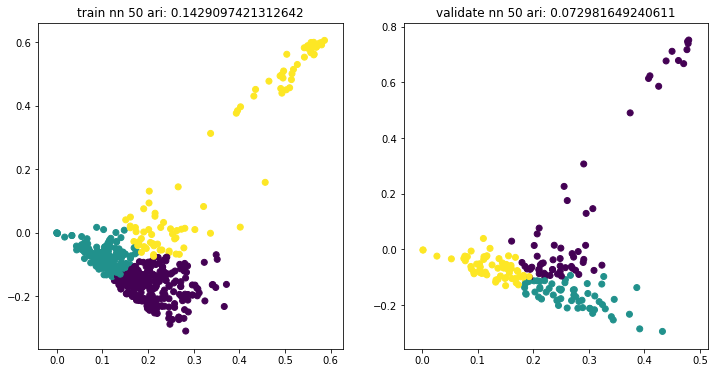

In [23]:
#nearest neighbors = 10
sc_nn10_ = SpectralClustering(n_clusters=n_clust_,
                             affinity='nearest_neighbors',
                             n_neighbors=10).fit(X_train_svd_)

predict_nn10_train_ = sc_nn10_.fit_predict(X_train_svd_)
predict_nn10_val_ = sc_nn10_.fit_predict(X_val_svd_)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:,0], X_train_svd_[:,1], c=predict_nn10_train_)
plt.title('train nn 10 ari: {}'.format(adjusted_rand_score(
    y_train_, predict_nn10_train_)))

plt.subplot(122)
plt.scatter(X_val_svd_[:,0], X_val_svd_[:,1], c=predict_nn10_val_)
plt.title('validate nn 10 ari: {}'.format(
    adjusted_rand_score(y_val_, predict_nn10_val_)))
plt.show()

#nearest neighbors = 25
sc_nn25_ = SpectralClustering(n_clusters=n_clust_,
                             affinity='nearest_neighbors',
                             n_neighbors=25).fit(X_train_svd_)

predict_nn25_train_ = sc_nn25_.fit_predict(X_train_svd_)
predict_nn25_val_ = sc_nn25_.fit_predict(X_val_svd_)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:,0], X_train_svd_[:,1], c=predict_nn25_train_)
plt.title('train nn 25 ari: {}'.format(adjusted_rand_score(
    y_train_, predict_nn25_train_)))

plt.subplot(122)
plt.scatter(X_val_svd_[:,0], X_val_svd_[:,1], c=predict_nn25_val_)
plt.title('validate nn 25 ari: {}'.format(
    adjusted_rand_score(y_val_, predict_nn25_val_)))
plt.show()

#nearest neighbors = 50
sc_nn5_ = SpectralClustering(n_clusters=n_clust_,
                            affinity='nearest_neighbors',
                            n_neighbors=50).fit(X_train_svd_)

predict_nn5_train_ = sc_nn5_.fit_predict(X_train_svd_)
predict_nn5_val_ = sc_nn5_.fit_predict(X_val_svd_)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:,0], X_train_svd_[:,1], c=predict_nn5_train_)
plt.title('train nn 50 ari: {}'.format(adjusted_rand_score(
    y_train_, predict_nn5_train_)))

plt.subplot(122)
plt.scatter(X_val_svd_[:,0], X_val_svd_[:,1], c=predict_nn5_val_)
plt.title('validate nn 50 ari: {}'.format(
    adjusted_rand_score(y_val_, predict_nn5_val_)))
plt.show()

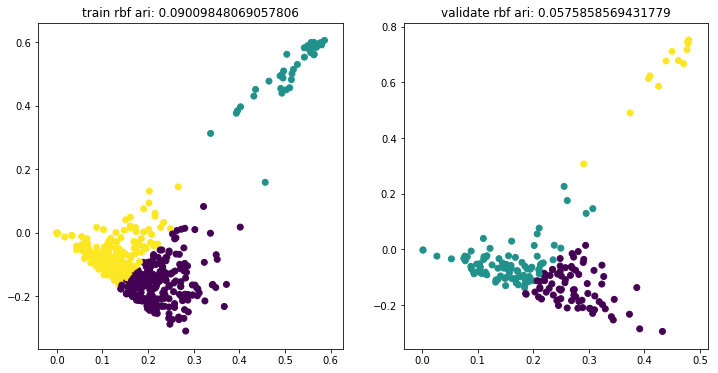

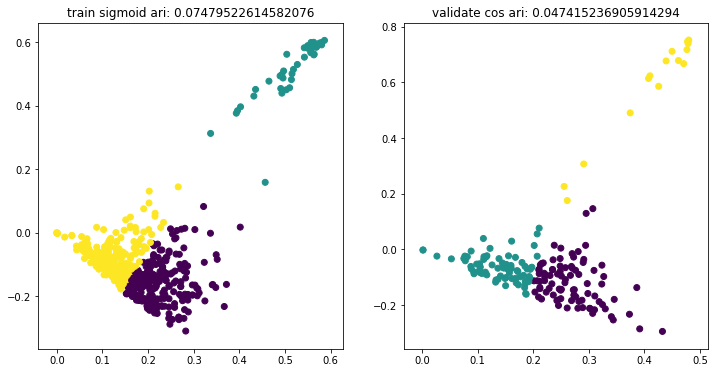

In [24]:
#rbf
sc_rbf_ = SpectralClustering(n_clusters=n_clust_,
                             affinity='rbf').fit(X_train_svd_)
predict_rbf_train_ = sc_rbf_.fit_predict(X_train_svd_)
predict_rbf_val_ = sc_rbf_.fit_predict(X_val_svd_)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:,0], X_train_svd_[:,1], c=predict_rbf_train_)
plt.title('train rbf ari: {}'.format(adjusted_rand_score(
    y_train_, predict_rbf_train_)))

plt.subplot(122)
plt.scatter(X_val_svd_[:,0], X_val_svd_[:,1], c=predict_rbf_val_)
plt.title('validate rbf ari: {}'.format(
    adjusted_rand_score(y_val_, predict_rbf_val_)))
plt.show()

#sigmoid
sc_sig_ = SpectralClustering(n_clusters=n_clust_,
                             affinity='sigmoid').fit(X_train_svd_)
predict_sig_train_ = sc_sig_.fit_predict(X_train_svd_)
predict_sig_val_ = sc_sig_.fit_predict(X_val_svd_)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:,0], X_train_svd_[:,1], c=predict_sig_train_)
plt.title('train sigmoid ari: {}'.format(adjusted_rand_score(
    y_train_, predict_sig_train_)))

plt.subplot(122)
plt.scatter(X_val_svd_[:,0], X_val_svd_[:,1], c=predict_sig_val_)
plt.title('validate sigmoid ari: {}'.format(
    adjusted_rand_score(y_val_, predict_sig_val_)))
plt.show()

## Classification Models: earn vs acq

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier().fit(X_train_tfidf, y_train)

print('vanilla KNN classifier')
print('train 10 cv mean: {}'.format(cross_val_score(knn, X_train_tfidf, y_train, cv=10).mean()))
print('validate 10 cv mean: {}'.format(cross_val_score(knn, X_val_tfidf, y_val, cv=10).mean()))

vanilla KNN classifier
train 10 cv mean: 0.9365832700170049
validate 10 cv mean: 0.9043980343980345


In [26]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier().fit(X_train_tfidf, y_train)

print('vanilla random forest classifier')
print('train 10 cv mean: {}'.format(cross_val_score(rfc, X_train_tfidf, y_train, cv=10).mean()))
print('validate 10 cv mean: {}'.format(cross_val_score(rfc, X_val_tfidf, y_val, cv=10).mean()))

vanilla random forest classifier
train 10 cv mean: 0.9621295994789969
validate 10 cv mean: 0.9558149058149059


In [27]:
import xgboost as xgb

xgbc = xgb.XGBClassifier().fit(X_train_tfidf, y_train)

print('vanilla xgboost classifier')
print('train 10 cv mean: {}'.format(cross_val_score(xgbc, X_train_tfidf, y_train, cv=10).mean()))
print('validate 10 cv mean: {}'.format(cross_val_score(xgbc, X_val_tfidf, y_val, cv=10).mean()))

vanilla xgboost classifier
train 10 cv mean: 0.9735509605991535
validate 10 cv mean: 0.954914004914005


## Classification Models: crude vs trade vs money

In [28]:
knn_ = KNeighborsClassifier().fit(X_train_tfidf_, y_train_)

print('vanilla KNN classifier')
print('train 10 cv mean: {}'.format(cross_val_score(knn_, X_train_tfidf_, y_train_, cv=10).mean()))
print('validate 10 cv mean: {}'.format(cross_val_score(knn_, X_val_tfidf_, y_val_, cv=10).mean()))

vanilla KNN classifier
train 10 cv mean: 0.9464790380828114
validate 10 cv mean: 0.8663708290333677


In [29]:
rfc_ = RandomForestClassifier().fit(X_train_tfidf_, y_train_)

print('vanilla random forest classifier')
print('train 10 cv mean: {}'.format(cross_val_score(rfc_, X_train_tfidf_, y_train_, cv=10).mean()))
print('validate 10 cv mean: {}'.format(cross_val_score(rfc_, X_val_tfidf_, y_val_, cv=10).mean()))

vanilla random forest classifier
train 10 cv mean: 0.9295314294370897
validate 10 cv mean: 0.9077124183006535


In [30]:
xgbc_ = xgb.XGBClassifier().fit(X_train_tfidf_, y_train_)

print('vanilla xgboost classifier')
print('train 10 cv mean: {}'.format(cross_val_score(xgbc_, X_train_tfidf_, y_train_, cv=10).mean()))
print('validate 10 cv mean: {}'.format(cross_val_score(xgbc_, X_val_tfidf_, y_val_, cv=10).mean()))

vanilla xgboost classifier
train 10 cv mean: 0.9649728538407784
validate 10 cv mean: 0.9450963192294461


In [31]:
stop here

SyntaxError: invalid syntax (<ipython-input-31-a96ba3aab008>, line 1)

## In progress

## NLP NN: word2vec

In [32]:
nlp = spacy.load('en')

In [33]:
#earn vs acq train & test sets
train_nlp = pd.concat([train_earn, train_acq]).reset_index(drop=True)
train_nlp.columns = ['category', 'fileid', 'article']
print('train_nlp shapes should match:\n{}'.format(train_nlp.shape))

for i, article in enumerate(train_nlp['article']):
    article_nlp = nlp(article)
    article = [token.lemma_ for token in article_nlp if not token.is_stop and not token.is_punct]
    train_nlp.loc[i, 'article'] = article

print(train_nlp.shape)
    
test_nlp = pd.concat([test_earn, test_acq]).reset_index(drop=True)
test_nlp.columns = ['category', 'fileid', 'article']
print('test_nlp shapes should match:\n{}'.format(test_nlp.shape))

for i, article in enumerate(test_nlp['article']):
    article_nlp = nlp(article)
    article = [token.lemma_ for token in article_nlp if not token.is_stop and not token.is_punct]
    test_nlp.loc[i, 'article'] = article

print(test_nlp.shape)

train_nlp shapes should match:
(4436, 3)
(4436, 3)
test_nlp shapes should match:
(1779, 3)
(1779, 3)


In [34]:
#crude vs trade vs money train & test sets
train_nlp_ = pd.concat([train_crude, train_trade, train_money]).reset_index(drop=True)
train_nlp_.columns = ['category', 'fileid', 'article']
print('train_nlp_ shapes should match:\n{}'.format(train_nlp_.shape))

for i, article in enumerate(train_nlp_['article']):
    article_nlp = nlp(article)
    article = [token.lemma_ for token in article_nlp if not token.is_stop and not token.is_punct]
    train_nlp_.loc[i, 'article'] = article

print(train_nlp_.shape)
    
test_nlp_ = pd.concat([test_crude, test_trade, test_money]).reset_index(drop=True)
test_nlp_.columns = ['category', 'fileid', 'article']
print('test_nlp_ shapes should match:\n{}'.format(test_nlp_.shape))

for i, article in enumerate(test_nlp_['article']):
    article_nlp = nlp(article)
    article = [token.lemma_ for token in article_nlp if not token.is_stop and not token.is_punct]
    test_nlp_.loc[i, 'article'] = article

print(test_nlp_.shape)

train_nlp_ shapes should match:
(725, 3)
(725, 3)
test_nlp_ shapes should match:
(284, 3)
(284, 3)


In [37]:
print(train_nlp['category'].value_counts())
print(test_nlp['category'].value_counts())

print(train_nlp_['category'].value_counts())
print(test_nlp_['category'].value_counts())

earn    2840
acq     1596
Name: category, dtype: int64
earn    1083
acq      696
Name: category, dtype: int64
crude       253
trade       250
money-fx    222
Name: category, dtype: int64
crude       121
money-fx     87
trade        76
Name: category, dtype: int64


In [116]:
from gensim.models import word2vec

train_wv = word2vec.Word2Vec(train_nlp['article'],
                              workers=2,
                              min_count=10,
                              window=6,
                              sg=0,
                              sample=1e-3,
                              size=300,
                              hs=1)

test_wv = word2vec.Word2Vec(test_nlp['article'],
                             workers=2,
                             min_count=10,
                             window=6,
                             sg=0,
                             sample=1e-3,
                             size=300,
                             hs=1)

In [123]:
train_vocab = train_wv.wv.vocab.keys()
train_vecs = train_wv.wv.syn0

In [188]:
subset = train_nlp[:5]
subset

,category,fileid,article
0,earn,training/10000,"[roger, lt, rog, see, st, qtr, net, significan..."
1,earn,training/10002,"[island, telephone, share, split, approve, lt,..."
2,earn,training/10008,"[questech, inc, lt, qtec, year, net, shr, loss..."
3,earn,training/10023,"[shoe, town, inc, lt, shu, year, end, jan, shr..."
4,earn,training/10027,"[american, nursery, product, lt, ansy, rd, qtr..."


In [195]:
import itertools
from itertools import combinations

mean_vecs = []

for i, article in enumerate(subset['article']):
    pairs = list(itertools.combinations(subset['article'][i], 2))
    temp_vecs = []
    for a, b in pairs:
        if a in train_vocab and b in train_vocab:
            temp_vecs.append(train_wv.wv.similarity(a, b))
    mean_vecs.append(np.mean(temp_vecs))
    
print(mean_vecs)
subset['similarity'] = mean_vecs
subset

[0.24627718, 0.15992674, 0.52889895, 0.39829347, 0.41798478]


,category,fileid,article,similarity
0,earn,training/10000,"[roger, lt, rog, see, st, qtr, net, significan...",0.246277
1,earn,training/10002,"[island, telephone, share, split, approve, lt,...",0.159927
2,earn,training/10008,"[questech, inc, lt, qtec, year, net, shr, loss...",0.528899
3,earn,training/10023,"[shoe, town, inc, lt, shu, year, end, jan, shr...",0.398293
4,earn,training/10027,"[american, nursery, product, lt, ansy, rd, qtr...",0.417985


In [192]:
mean_vecs

[0.24627718, 0.15992674, 0.52889895, 0.39829347, 0.41798478]

In [196]:
#ok now run the full train_nlp df through this
mean_vecs = []
for i, article in enumerate(train_nlp['article']):
    pairs = list(itertools.combinations(train_nlp['article'][i], 2))
    temp_vecs = []
    for a, b in pairs:
        if a in train_vocab and b in train_vocab:
            temp_vecs.append(train_wv.wv.similarity(a, b))
    mean_vecs.append(np.mean(temp_vecs))
    
train_nlp['similarity'] = mean_vecs
train_nlp[:20]

,category,fileid,article,similarity
0,earn,training/10000,"[roger, lt, rog, see, st, qtr, net, significan...",0.246277
1,earn,training/10002,"[island, telephone, share, split, approve, lt,...",0.159927
2,earn,training/10008,"[questech, inc, lt, qtec, year, net, shr, loss...",0.528899
3,earn,training/10023,"[shoe, town, inc, lt, shu, year, end, jan, shr...",0.398293
4,earn,training/10027,"[american, nursery, product, lt, ansy, rd, qtr...",0.417985
5,earn,training/1003,"[national, fsi, inc, lt, nfsi, th, qtr, loss, ...",0.347845
6,earn,training/10032,"[discus, corp, lt, disc, th, qtr, loss, shr, l...",0.618528
7,earn,training/10035,"[entertainment, publication, see, ct, shr, rd,...",0.366127
8,earn,training/10037,"[pay, n, pak, store, inc, lt, pnp, th, qtr, fe...",0.480004
9,earn,training/10040,"[american, nursery, product, lt, ansy, rd, qtr...",0.450332


In [ ]:
X_train_vectors = X_train_w2v.wv.syn0
#X_val_vectors = X_val_w2v.wv.syn0

X_train_norm = normalize(X_train_vectors)
#X_val_norm = normalize(X_val_vectors)

X_train_svd = TruncatedSVD(2).fit_transform(X_train_norm)
#X_val_svd = TruncatedSVD(2).fit_transform(X_val_norm)

n_clust = 2

In [ ]:
print(X_train_vectors.shape)
print(X_train_norm.shape)
print(X_train_svd.shape)

In [ ]:
kmeans = KMeans(n_clusters=n_clust,
                init='k-means++',
                n_init=10).fit(X_train_svd)

y_pred_train = kmeans.predict(X_train_svd)

In [ ]:
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_pred_train)
plt.show()

In [ ]:
sc_nn10 = SpectralClustering(n_clusters=n_clust,
                             affinity='nearest_neighbors',
                             n_neighbors=10).fit(X_train_svd)

predict_nn10_train = sc_nn10.fit_predict(X_train_svd)

plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_nn10_train)
plt.show()